# Domain decomposition example using shallow water gravity wave

This example is to demonstrate how to decompose domain and run computation
on Dask's clusters using domain split API. This notebook is based on
1_gravity_wave notebook, and it is recommended to familiarize with it first.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from multimodemodel import StaggeredGrid, Variable, Parameters
from dask.distributed import LocalCluster, Client
from multimodemodel.API_implementation import DomainState

In [2]:
def plot(input: DomainState):
    plt.pcolormesh(input.eta.grid.x, input.eta.grid.y, input.eta.safe_data, shading='auto')
    plt.axis('equal')
    plt.colorbar()
    plt.show()

# Prepare grid

The first step is to prepare grid and set the initial state. 
It is performed in the same way as in any other case.

In [3]:
nx, ny = 100, 100
dx, dy = 1., 1.

x = np.arange(0., dx * nx, dx)
y = np.arange(0., dy * ny, dy)

c_grid = StaggeredGrid.cartesian_c_grid(x, y)

u = np.zeros((nx, ny))
v = np.zeros((nx, ny))
eta = np.exp(-((c_grid.eta.x - nx // 2) ** 2 + (c_grid.eta.y - ny // 2) ** 2) / 10. ** 2)

# Create DomainState

From API_implementation import DomainState, which is child of State class,
but also has additional functionalities for domain decomposition

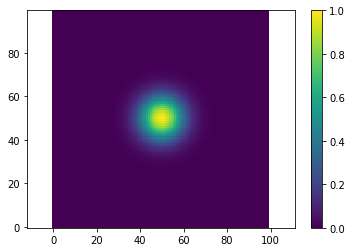

In [4]:
from collections import deque

initial_state = DomainState(
    u=Variable(u, c_grid.u),
    v=Variable(v, c_grid.v),
    eta=Variable(eta, c_grid.eta),
    h=deque([], maxlen=3)
)

plot(initial_state)

Create Dask Client based on cluster of your choice. 
There should be just one thread per worker.

In [5]:
cluster = LocalCluster(n_workers=4, threads_per_worker=1, memory_limit="2GB")

client = Client(cluster)

distributed.diskutils - INFO - Found stale lock file and directory '/home/knowak/PycharmProjects/multimode-model/examples/dask-worker-space/worker-_lxvnu5_', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/knowak/PycharmProjects/multimode-model/examples/dask-worker-space/worker-0l3pn26j', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/knowak/PycharmProjects/multimode-model/examples/dask-worker-space/worker-eyi6phfy', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/knowak/PycharmProjects/multimode-model/examples/dask-worker-space/worker-x25gnrai', purging


In [6]:
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:34725,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:40521,Total threads: 1
Dashboard: http://127.0.0.1:42331/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:42255,


# Perform computation

Use magic function from API to perform computation. Import classes for solving given problem.

In [7]:
from multimodemodel.API_implementation import Tail, GeneralSolver
from multimodemodel.domain_split_API import magic
from multimodemodel.integrate import non_rotating_swe, adams_bashforth3

start = time.time()

# Make Solver for specific use case
g = GeneralSolver(non_rotating_swe, adams_bashforth3, 0.001)
# Returns list of Dask's Futres on each subdomain
tmp = magic(initial_state, 10, 800, (1,), g, Tail(), client)
f = client.submit(DomainState.merge, tmp, 1) # Merge all subdomains into one
out = f.result() # Get results

end = time.time()
print("Computation time: {}".format(end - start))

Computation time: 113.54374241828918


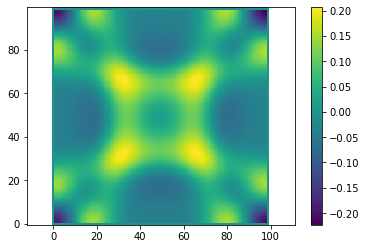

In [8]:
plot(out)

# Implementation of Subtropical gyre example

In [9]:
c_grid = StaggeredGrid.regular_lat_lon_c_grid(
    lon_start=0.0,
    lon_end=60.0,
    lat_start=20.0,
    lat_end=60.0,
    nx=60 * 2 + 1,
    ny=40 * 2 + 1,
)

H_e = 300.  # Depth over which the wind forcing acts uniformly, a.k.a. Ekman layer depth

In [11]:
import functools as ft
import operator as op
from multimodemodel import (
    pressure_gradient_i, pressure_gradient_j,
    coriolis_i, coriolis_j,
    divergence_i, divergence_j,
    State, f_on_sphere
)

def zonal_wind(state, params):
    tau = 0.01 * np.sin(
        np.pi  # convert to radians
        * (state.u.grid.y - 40.)  # use latitude of the grid on which u is defined
        / 20.
    )
    return State(
        u=Variable(tau / H_e / params.rho_0, state.u.grid),
        v=Variable(None, state.v.grid),
        eta=Variable(None, state.eta.grid),
    )


def linear_damping(state: State, params):
    r = 1e-6
    return State(
        u=Variable(-r * state.u.safe_data, state.u.grid),
        v=Variable(-r * state.v.safe_data, state.v.grid),
        eta=Variable(None, state.eta.grid),
    )


terms = [
    pressure_gradient_i, pressure_gradient_j,
    coriolis_i, coriolis_j,
    divergence_i, divergence_j,
    zonal_wind, linear_damping
]


def rhs(state, params):
    return ft.reduce(op.add, (term(state, params) for term in terms))

In [12]:
params = Parameters(
    coriolis_func=f_on_sphere(omega=7.272205e-05),
    on_grid=c_grid,
    H=500.,
    g=2.5 ** 2 / 500.,
)


In [13]:
initial_state = DomainState(
        u=Variable(None, c_grid.u),
        v=Variable(None, c_grid.v),
        eta=Variable(None, c_grid.eta),
        h=deque([], maxlen=3),
        p=params
    )

In [16]:
start = time.time()

# Make Solver for specific use case
g = GeneralSolver(rhs, adams_bashforth3, 0.05)
# Returns list of Dask's Futres on each subdomain
tmp = magic(initial_state, 4, 2000, (1,), g, Tail(), client)
f = client.submit(DomainState.merge, tmp, 1)  # Merge all subdomains into one
out = f.result()  # Get results

end = time.time()
print("Computation time: {}".format(end - start))

Computation time: 168.92992615699768


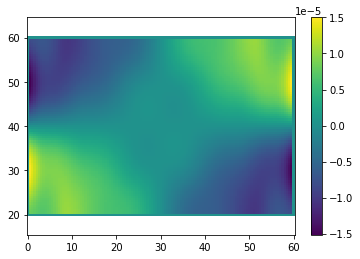

In [17]:
plot(out)